# Solving Tents and Trees using Numpy and Pyomo
In order to improve my skills in Numpy and linear programming with Pyomo, I created a little notebook to solve the tents and trees puzzle often found in newspapers. The game works as follows:
- Place tents in the grid (camping).
- The numbers outside the grid show how many tents in that row or column.
- Tents can only be planted next to trees (horizontally or vetrically)
- Tents do not touch each other, not even diagonally.

<img src="./examples/example1.png" alt="Example" style="width: 250px;"/>

First, we load the neccesary packages and encode the tree positions, and column and row limits.

In [1]:
import numpy as np
import pyomo.environ as pyo

In [2]:
from puzzle_detection import puzzle_detection
puzzle = puzzle_detection.PuzzleDetector('./examples/example1.png')
puzzle.detect_squares()
puzzle.detect_trees()

In [3]:
# Encode the limits
# Example 1
limits_c = [1,1,1,0,1,3,1,2]
limits_r = [1,2,0,3,0,2,1,1]

# Example 2
# limits_c = [2,2,2,3,2,2,2,3,0,5,0,5]
# limits_r = [3,3,2,1,2,3,2,2,2,4,0,4]

# Encode the trees.
# forest = np.array([[0,0], [0,6], [1,4], [2,6], [3,0], [3,3], [5,4], [5,7], [6,2], [7,6]])
forest = puzzle.tree_indices

# Dimensions of the camping (row and columnn length)
# dimension = 8
dimension = puzzle.dimension

We define a class for the Camping. This class can assign positions to Tents, Trees or any other figure. The show method will visualize the campsite.

In [4]:
class Camping:
    
    def __init__(self, forest, dimension, limits_c, limits_r):
        
        # Initialize the camping
        self.camping = np.full((dimension, dimension), fill_value='.', dtype='object')
        
        # Add trees
        self.allocate(forest, 'T')
        
        # Store the limits
        self.limits_c = [str(limit) for limit in limits_c]
        self.limits_r = [str(limit) for limit in limits_r]
        
    def allocate(self, indices, str_symbol):
        """Set indices with a symbol"""
        x, y = indices.T
        self.camping[x,y] = str_symbol
        
    def show(self):
        """Visualize the campsite"""
        camping = np.vstack([self.camping, self.limits_c])
        limits_r = self.limits_r + ['.']
        camping = np.vstack([limits_r, camping.T])
        print(camping.T)

Let's see how the camping looks like when show using our class

In [5]:
camping = Camping(forest, dimension, limits_c, limits_r)
camping.show()

[['1' 'T' '.' '.' '.' '.' '.' 'T' '.']
 ['2' '.' '.' '.' '.' 'T' '.' '.' '.']
 ['0' '.' '.' '.' '.' '.' '.' 'T' '.']
 ['3' 'T' '.' '.' 'T' '.' '.' '.' '.']
 ['0' '.' '.' '.' '.' '.' '.' '.' '.']
 ['2' '.' '.' '.' '.' 'T' '.' '.' 'T']
 ['1' '.' '.' 'T' '.' '.' '.' '.' '.']
 ['1' '.' '.' '.' '.' '.' '.' 'T' '.']
 ['.' '1' '1' '1' '0' '1' '3' '1' '2']]


We see that the open spots are indicated with a '.'. The trees are referred to with 'T'. Now we start preparing the data for linear programming. Let's start with the first rule:

- Tents can only be planted next to trees (horizontally or vetrically)

Thus the only places in the campsite next to trees are capsites. 

In [6]:
# Replicate the forest 4 times to assign campsites to each cardinal directionthe trees
# Shape (4, number of trees, 2)
campsites = np.array([forest for _ in range(4)])

campsites[0,:,0] = campsites[0,:,0] + 1
campsites[1,:,0] = campsites[1,:,0] - 1
campsites[2,:,1] = campsites[2,:,1] + 1
campsites[3,:,1] = campsites[3,:,1] - 1

# Flatten the 4 nested arrays
campsites = campsites.reshape(4*len(forest),2)

# Remove duplicate campsites
campsites = np.unique(campsites, axis=0)

#Remove campsites that are located outside the campsite
is_outside = (campsites >= dimension) | (campsites < 0)
idx = np.any(is_outside, axis=1)
campsites = campsites[~idx]

#Remove campsites located on a Tree
idx = camping.camping[campsites.T[0], campsites.T[1]] != 'T'
campsites = campsites[idx]

Let's have a look at a subsection of the campsites, and add them to our camping as 'x'.

In [7]:
campsites[:10]

array([[0, 1],
       [0, 4],
       [0, 5],
       [0, 7],
       [1, 0],
       [1, 3],
       [1, 5],
       [1, 6],
       [2, 0],
       [2, 3]], dtype=int64)

In [8]:
# Add campsites to camping
camping.allocate(campsites, 'x')
camping.show()

[['1' 'T' 'x' '.' '.' 'x' 'x' 'T' 'x']
 ['2' 'x' '.' '.' 'x' 'T' 'x' 'x' '.']
 ['0' 'x' '.' '.' 'x' 'x' 'x' 'T' 'x']
 ['3' 'T' 'x' 'x' 'T' 'x' '.' 'x' '.']
 ['0' 'x' '.' '.' 'x' 'x' '.' '.' 'x']
 ['2' '.' '.' 'x' 'x' 'T' 'x' 'x' 'T']
 ['1' '.' 'x' 'T' 'x' 'x' '.' 'x' 'x']
 ['1' '.' '.' 'x' '.' '.' 'x' 'T' 'x']
 ['.' '1' '1' '1' '0' '1' '3' '1' '2']]


By allowing the linear programming solution to only place tents on the spots marked with X, we have satisfied the first rule. Let's move on to the next rule:

- Tents do not touch each other, not even diagonally.

In order to satisfy this constraint, a 2 x 2 section of the campsite can only contain a single tent. To implement this, we will create campsite groups and add all the campsites to the respective groups. We have a campsite group for each index of the camping.

In [9]:
# Obtain camping group - camping indices - to loop over and add campsites that are within the group
camping_indices = np.stack(np.indices(camping.camping.shape), axis=2).reshape(-1,2)
camping_indices[0:10]

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [0, 5],
       [0, 6],
       [0, 7],
       [1, 0],
       [1, 1]])

In [10]:
campsites_groups = np.array([], dtype='int').reshape(0,3)

campsites_rows, campsites_cols = campsites.T

# Loop over the camping indeces and add any campsites within the group
for idx, (top_left_row_idx, top_left_col_idx) in enumerate(camping_indices):
    
    # Calculate distance of each campsite to the top left index of the 2 x 2 group
    row_diff = campsites_rows - top_left_row_idx
    col_diff = campsites_cols - top_left_col_idx
    
    # Assess if campsite belongs to the group
    campsites_in_group = campsites[(row_diff <= 1) & (row_diff >=0) & (col_diff <= 1) & (col_diff >=0)]
    
    # If there are campsites in the group, add these to the array of campsite_groups
    if len(campsites_in_group) > 0:
        campsites_in_group = np.insert(campsites_in_group, 0, idx, axis=1)
        campsites_groups = np.append(campsites_groups, campsites_in_group, axis=0)

# Campsites_groups is np.array with shape (campsites, (campsite_group, row_idx, col_idx))
campsites_groups[:10]

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 1],
       [2, 1, 3],
       [3, 0, 4],
       [3, 1, 3],
       [4, 0, 4],
       [4, 0, 5],
       [4, 1, 5],
       [5, 0, 5]], dtype=int64)

We now have a numpy array that describe all the required information for modelling. The first index contains the campsite group, to prevent placement of tents horizontal and diagonal next to each other. The second and third index contain the row and column index of the campsite. A set of campsites can be obtained by taking the unique entries of the second and third axis.

In [11]:
campsites_set = np.unique(np.take(campsites_groups, [1,2], axis=1), axis=0)
campsites_set[:10]

array([[0, 1],
       [0, 4],
       [0, 5],
       [0, 7],
       [1, 0],
       [1, 3],
       [1, 5],
       [1, 6],
       [2, 0],
       [2, 3]], dtype=int64)

# Modelling the game as a linear programming problem
With all the building blocks in place, we can start solving the game. We use pyomo as to solve the game as a linear programming problem. 

In [12]:
m = pyo.ConcreteModel()

Let's add all the constraints one by one to define the linear programming problem. First up:
- Tents can only be planted next to trees (horizontally or vetrically)

Let's create a Binary variable for each possible campsite in our campsite sets.

In [13]:
m.Campsites = pyo.Set(initialize=[tuple(site) for site in campsites_set])

m.tents = pyo.Var(m.Campsites, within=pyo.Binary)

- The numbers outside the grid show how many tents in that row or column.

In [14]:
m.Dimension = pyo.Set(initialize=range(dimension))

def col_lim_rule(m, i):
    """Ensure that the sum of tents in a column is equal to the required number of tents"""
    return sum(m.tents[site] for site in m.Campsites if site[1] == i) == limits_c[i] 

def row_lim_rule(m, i):
    """Ensure that the sum of tents in a row is equal to the required number of tents"""
    return sum(m.tents[site] for site in m.Campsites if site[0] == i) == limits_r[i]

# Add the constraints to the model
m.c_col = pyo.Constraint(m.Dimension, rule=col_lim_rule)
m.c_row = pyo.Constraint(m.Dimension, rule=row_lim_rule)

- Tents do not touch each other, not even diagonally.

We add the campsites groups as constraints. Recall that for eacht group the first index is the group number, the second and third index refer to the campsite location.

In [15]:
m.Group_idxs = pyo.Set(initialize=np.unique(campsites_groups.take(0, axis=1)))
m.CampsiteGroups = pyo.Set(initialize=[tuple(site) for site in campsites_groups])

def campsites_group_rule(m, i):
    """Ensure that no more than 1 tent is allocated per group"""
    return sum(m.tents[site[1], site[2]] for site in m.CampsiteGroups if site[0] == i) <= 1

# Add the contraint for each group.
m.c_group = pyo.Constraint(m.Group_idxs, rule=campsites_group_rule)

# Solving the game
With all the restraints in place, we can now solve te game. Pyomo requires an objective, that is optimized. In our case, no such objective exists, therefor we add an constant objective and continue to solve the game!

In [16]:
# Add a constant objective
m.obj = pyo.Objective(expr=1.0)

opt = pyo.SolverFactory('glpk')
res = opt.solve(m)

    solver failure.


Let's have a look at how our solution looks like!

In [17]:
for v in m.component_objects(pyo.Var, active=True):
    for index in v:
        value = str(int(pyo.value(v[index])))
        camping.allocate(np.array([index]), value)
        
camping.show()

[['1' 'T' '0' '.' '.' '0' '0' 'T' '1']
 ['2' '1' '.' '.' '0' 'T' '1' '0' '.']
 ['0' '0' '.' '.' '0' '0' '0' 'T' '0']
 ['3' 'T' '1' '0' 'T' '1' '.' '1' '.']
 ['0' '0' '.' '.' '0' '0' '.' '.' '0']
 ['2' '.' '.' '1' '0' 'T' '1' '0' 'T']
 ['1' '.' '0' 'T' '0' '0' '.' '0' '1']
 ['1' '.' '.' '0' '.' '.' '1' 'T' '0']
 ['.' '1' '1' '1' '0' '1' '3' '1' '2']]


Let's see the solution on the original image!

10


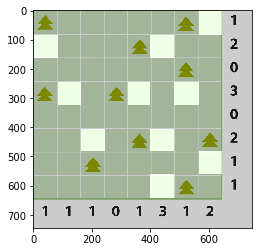

In [18]:
puzzle.show_squares(camping.camping == '1', filename='example1_solution')